In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import sklearn
import matplotlib.pyplot as plt
from datetime import datetime
from torch.nn.functional import mse_loss
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from utils_pp import replace_cell_names_with_id
from utils_pp import Encoder
from utils_pp import EarlyStopper
from torch.utils.tensorboard import SummaryWriter
%load_ext autoreload
%autoreload 2

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
columns = ["cell_line", "drugA_name", "drugB_name", "drugA_conc", "drugB_conc", "target"]
df_train = pd.read_csv("../data_raw/oneil.csv", usecols=(1,2,3,4,5,12)).iloc[:,[0,1,3,2,4,5]].set_axis(columns, axis=1)
# df_train["cell_line"]
df_test = pd.read_csv("../data/test_yosua.csv").set_axis(columns + ["std"], axis=1).convert_dtypes()

drug_data = pd.read_pickle("../data/drug_data.pkl.compress", compression="gzip")
cell_data = pd.read_pickle("../data/cell_line_data.pkl.compress", compression="gzip")

df_train = replace_cell_names_with_id(dataframe=df_train, mapping_file="../data/mappingccl.csv")
df_test = replace_cell_names_with_id(dataframe=df_test, mapping_file="../data/mappingccl.csv")
df_train = df_train[df_train.cell_line.isin(cell_data.index)]
df_train, df_val = train_test_split(df_train, test_size=0.2, shuffle=True)
cell_data = cell_data[cell_data.index.isin(pd.concat([df_train.cell_line, df_test.cell_line]))]
drug_data = drug_data[drug_data.index.isin(pd.concat([df_train.drugA_name, df_train.drugB_name,df_test.drugA_name, df_test.drugB_name]))]
print("oneil", df_train.memory_usage().sum()/1e6, df_train.shape,"\n", df_train.dtypes)
print("drug_feat", drug_data.memory_usage().sum()/1e6, drug_data.shape)
print("cell_feat", cell_data.memory_usage().sum()/1e6, cell_data.shape)
drug_length = drug_data.shape[1]
cell_length = cell_data.shape[1]

oneil 13.13536 (234560, 6) 
 cell_line      object
drugA_name     object
drugB_name     object
drugA_conc    float64
drugB_conc    float64
target        float64
dtype: object
drug_feat 0.427236 (42, 2412)
cell_feat 0.686136 (32, 5011)


In [15]:
class AE_DNN(torch.nn.Module):
    def __init__(self, h_sizes):
        super().__init__()
        self.drug_encoder = Encoder(h_sizes=[drug_length, 512, 512, 256, 512, 512])
        self.cell_encoder = Encoder(h_sizes=[cell_length, 512, 512, 256, 512, 512])
        self.hidden = nn.ModuleList()
        for k in range(len(h_sizes)-1):
            self.hidden.append(nn.Linear(h_sizes[k], h_sizes[k+1]))
            self.hidden.append(nn.Dropout(0.1))
            self.hidden.append(nn.ReLU())
        self.hidden.append(nn.Linear(h_sizes[-1], 1))
    def forward(self, x):
        drug_A, drug_B, cell, drugA_conc, drugB_conc = torch.split(x, [drug_length, drug_length, cell_length, 1, 1], dim=1)
        drug_A_emb = self.drug_encoder(drug_A)
        drug_B_emb = self.drug_encoder(drug_B)
        cell_emb = self.cell_encoder(cell)
        x = torch.concatenate([drug_A_emb, drug_B_emb, cell_emb, drugA_conc, drugB_conc], dim=1)
        for lay in self.hidden:
            # print(torch.sum(torch.isnan(x)))
            # print(torch.sum(x>1e3))
            x = lay(x)
        return x
model = AE_DNN([770,32])
yi = model.forward(xi)
print(yi.shape)

torch.Size([256, 1])


In [16]:
def train_one_epoch(model, epoch_index, tb_writer, training_loader, optimizer, loss_fn, device, L1, verbose=False):
    running_loss = 0.
    last_loss = 0.
    model = model.to(device)
    for i, data in enumerate(training_loader):
        inputs, labels = data
        inputs = inputs.to(device=device)
        labels = labels.to(device=device)
        # Zero your gradients for every batch!
        optimizer.zero_grad()
        outputs = model.forward(inputs)

        params = torch.cat([x.view(-1) for x in model.parameters()])
        l1_regularization = L1 * torch.linalg.vector_norm(params, 1)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels) + l1_regularization
        loss.backward()

        # Adjust learning weights
        optimizer.step()
        running_loss += loss.item()
        if i % 10 == 9:
            last_loss = running_loss / 10 # loss per batch
            # print('  batch {} loss: {}'.format(i + 1, last_loss), outputs[0][0].item(), labels[0][0].item())
            # tb_x = epoch_index * len(training_loader) + i + 1
            # tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [17]:
def training(data_train, data_val, L):


    train_set  = Dataset_from_pd(data_train, drug_data, cell_data)
    val_set = Dataset_from_pd(data_val, drug_data, cell_data)
    test_set  = Dataset_from_pd(df_test, drug_data, cell_data)
    train_dl = DataLoader(train_set, batch_size=batch_size)
    xi, yi = next(iter(train_dl))
    val_dl = DataLoader(val_set, batch_size=batch_size)
    test_dl = DataLoader(test_set, batch_size=batch_size)

    model = AE_DNN([770,256,256,256, 128,128,128,64,64,64])
    model.drug_encoder = Encoder(model.drug_encoder.h_sizes)
    model.drug_encoder.encoder.load_state_dict(torch.load("../models/drug_encoder.pt"))
    model.cell_encoder = Encoder(model.cell_encoder.h_sizes)
    model.cell_encoder.encoder.load_state_dict(torch.load("../models/cell_encoder.pt"))
    model.drug_encoder.eval()
    model.cell_encoder.eval()
    # print(summary(model.to("cuda"), 770))
    optimizer = torch.optim.Adam(model.hidden.parameters(), lr=1e-3)
    loss_fn = torch.nn.MSELoss()
    mae_fn = torch.nn.L1Loss()
    # Initializing in a separate cell so we can easily add more epochs to the same run
    # timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    # writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
    early_stopper = EarlyStopper(patience=10)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.5, verbose=True, patience=5, min_lr=1e-7)

    epoch_number = 0
    EPOCHS = 100

    for epoch in range(EPOCHS):

        # Make sure gradient tracking is on, and do a pass over the data
        model.hidden.train(True)
        model = model.to(device=device)
        avg_loss = train_one_epoch(model, epoch_number, "writer", train_dl, optimizer, loss_fn, device, 1e-6)
        # Set the model to evaluation mode, disabling dropout and using population
        # statistics for batch normalization.
        model.eval()

        running_vloss = 0.0
        running_MAE = 0.
        running_PCC = 0.
        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            for i, vdata in enumerate(val_dl):

                vinputs, vlabels = vdata
                vinputs = vinputs.to(device)
                vlabels = vlabels.to(device)
                voutputs = model(vinputs)
                vloss = loss_fn(voutputs, vlabels)
                running_vloss += vloss.item()

                vx = voutputs - torch.mean(voutputs)
                vy = vlabels - torch.mean(vlabels)
                cost = torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2)))
                running_PCC += cost.item()

                mae_loss = mae_fn(voutputs, vlabels)
                running_MAE += mae_loss.item()

        avg_MAE = running_MAE/(i+1)
        avg_PCC = running_PCC/(i+1)
        avg_vloss = running_vloss / (i + 1)
        print('epoch {} LOSS train {} valid {} mae {} pcc{} '.format(epoch_number+1, avg_loss, avg_vloss, avg_MAE, avg_PCC))
        scheduler.step(avg_loss)

        if early_stopper.early_stop(avg_vloss):             
            break
        epoch_number += 1
    
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(test_dl):
            inputs, labels = data
            inputs = inputs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(inputs)
            loss_test = loss_fn(outputs, labels).item()
            mae_test = mae_fn(outputs, labels).item()
            vx = voutputs - torch.mean(outputs)
            vy = vlabels - torch.mean(labels)
            pcc_test = torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2))).item()
    print([avg_vloss, avg_MAE, avg_PCC, loss_test, mae_test, pcc_test])
    L.append([avg_vloss, avg_MAE, avg_PCC, loss_test, mae_test, pcc_test, outputs.to("cpu").numpy().reshape(-1)])


In [9]:
model = AE_DNN([770,256,256,256, 128,128,128,64,64,64])
model.load_state_dict(torch.load("../models/ae_dnn.pt"))

RuntimeError: Error(s) in loading state_dict for AE_DNN:
	Missing key(s) in state_dict: "hidden.6.weight", "hidden.6.bias", "hidden.9.weight", "hidden.9.bias", "hidden.12.weight", "hidden.12.bias", "hidden.15.weight", "hidden.15.bias", "hidden.18.weight", "hidden.18.bias", "hidden.21.weight", "hidden.21.bias", "hidden.24.weight", "hidden.24.bias", "hidden.27.weight", "hidden.27.bias". 
	size mismatch for hidden.0.weight: copying a param with shape torch.Size([32, 770]) from checkpoint, the shape in current model is torch.Size([256, 770]).
	size mismatch for hidden.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for hidden.3.weight: copying a param with shape torch.Size([1, 32]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for hidden.3.bias: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([256]).

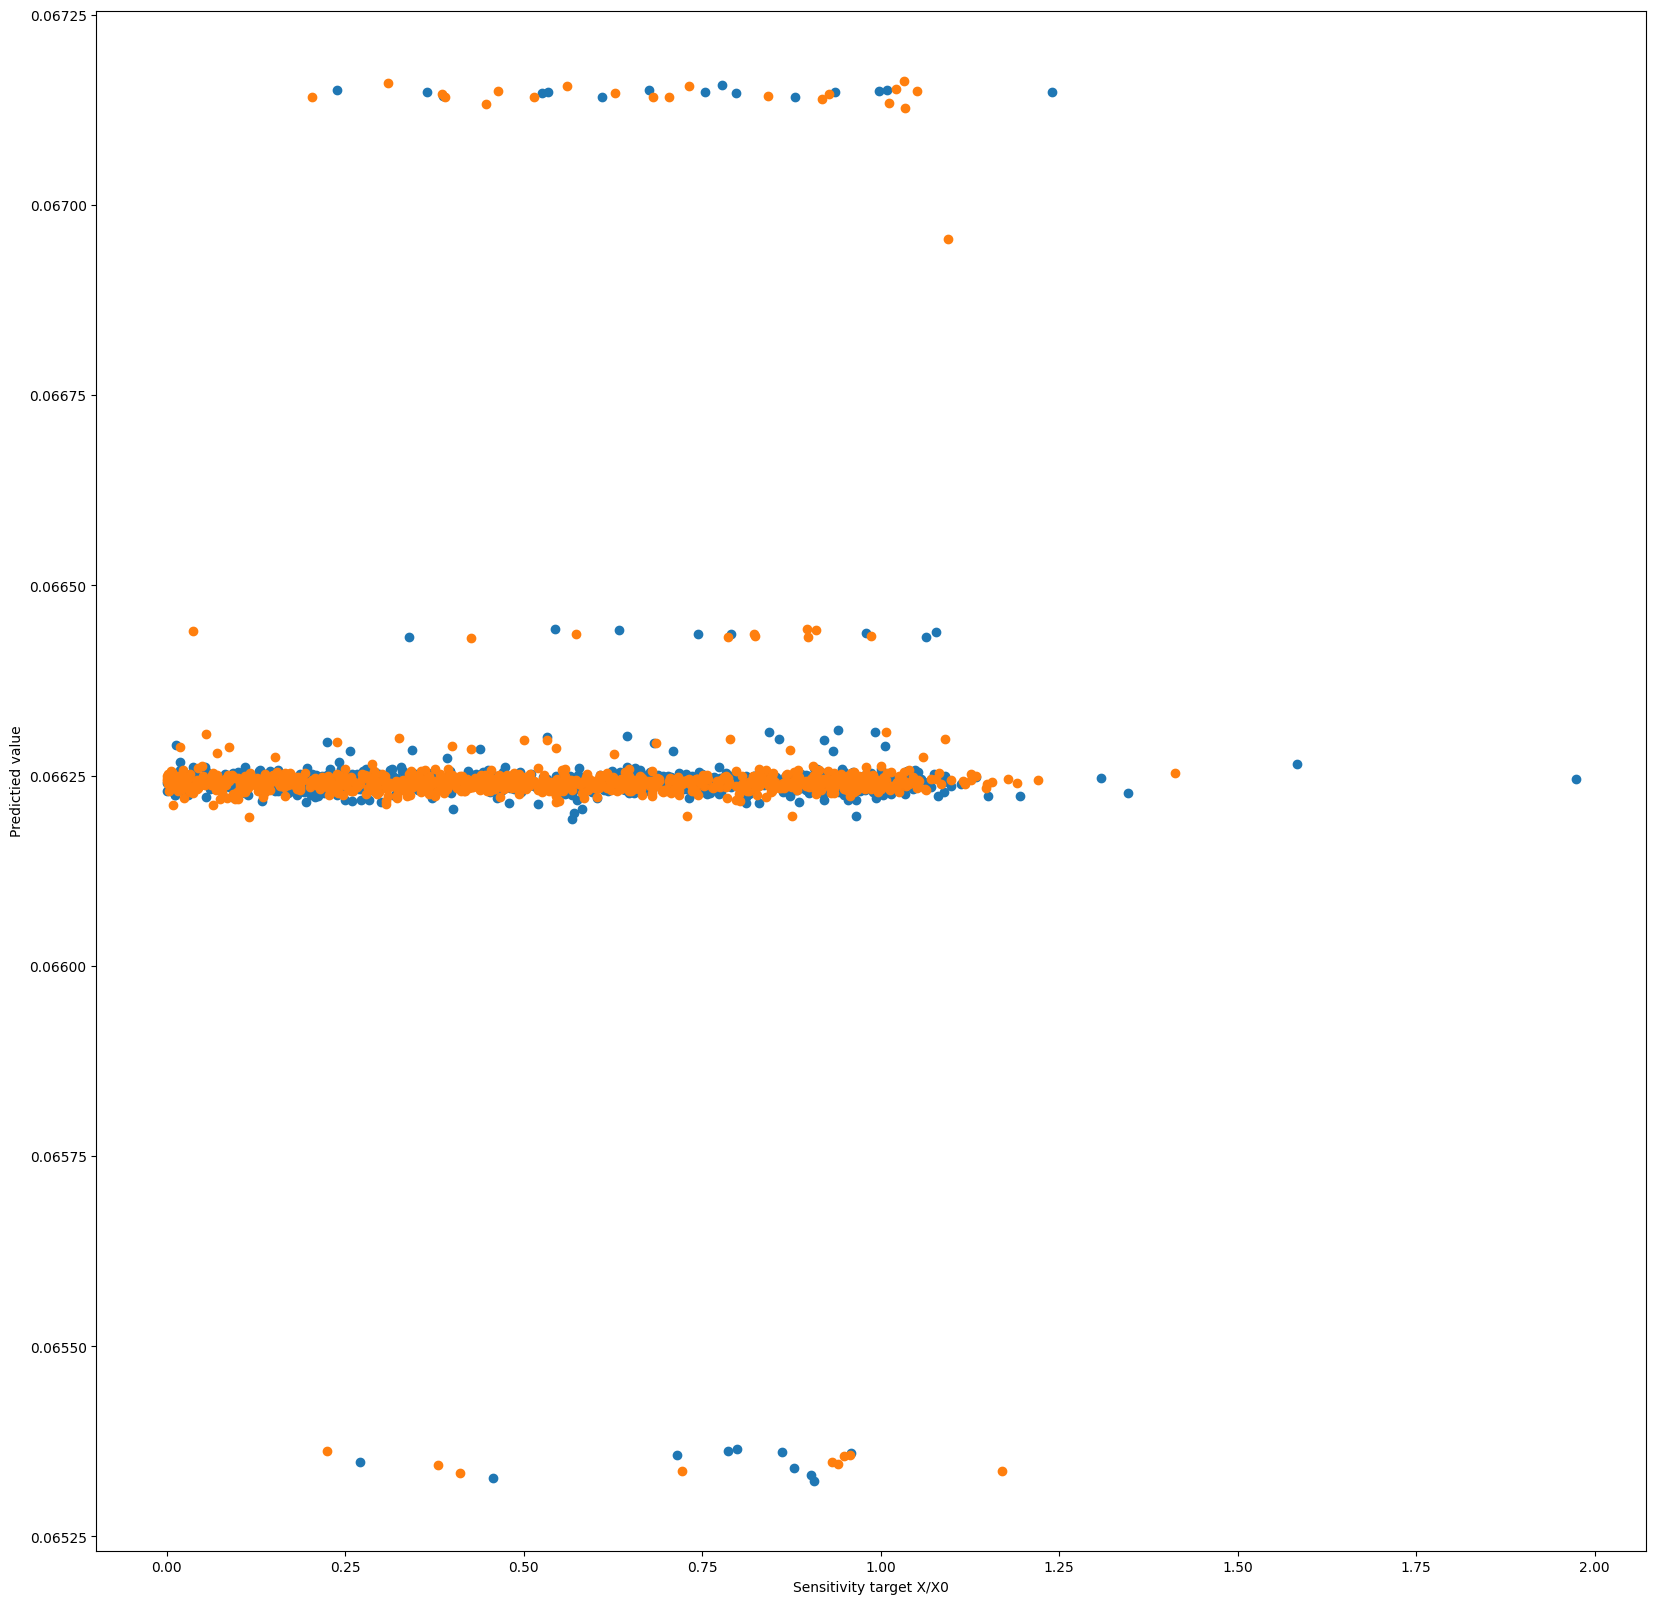

In [10]:
import matplotlib.pyplot as plt
batch_size=1024
val_set = Dataset_from_pd(df_val, drug_data, cell_data)
val_dl = DataLoader(val_set, batch_size=batch_size)

plt.subplots(figsize=(20, 20))
model.eval()
model.to(device)
number = 0
with torch.no_grad():
    for i, data in enumerate(val_dl):
        inputs, labels = data
        inputs = inputs.to(device=device)
        labels = labels.to(device=device)
        outputs = model(inputs)
        plt.scatter(labels.view(-1).to("cpu").numpy(), outputs.view(-1).to("cpu").numpy())
        plt.xlabel("Sensitivity target X/X0")
        plt.ylabel("Predictied value")

        number += labels.view(-1).shape[0]
        if i==1:break
plt.show()
#         loss_test = loss_fn(outputs, labels).item()
#         mae_test = mae_fn(outputs, labels).item()
#         vx = voutputs - torch.mean(outputs)
#         vy = vlabels - torch.mean(labels)
#         pcc_test = torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2))).item()
# print([avg_vloss, avg_MAE, avg_PCC, loss_test, mae_test, pcc_test])
# L.append([avg_vloss, avg_MAE, avg_PCC, loss_test, mae_test, pcc_test, outputs.to("cpu").numpy().reshape(-1)])

In [9]:
columns = ["cell_line", "drugA_name", "drugB_name", "drugA_conc", "drugB_conc", "target"]
df_train = pd.read_csv("../data_raw/oneil.csv", usecols=(1,2,3,4,5,12)).iloc[:,[0,1,3,2,4,5]].set_axis(columns, axis=1)
df_test = pd.read_csv("../data/test_yosua.csv").set_axis(columns + ["std"], axis=1).convert_dtypes()
df_train = replace_cell_names_with_id(dataframe=df_train, mapping_file="../data/mappingccl.csv")
df_test = replace_cell_names_with_id(dataframe=df_test, mapping_file="../data/mappingccl.csv")
df_train = df_train[df_train.cell_line.isin(cell_data.index)]

KeyboardInterrupt: 

In [ ]:
unique_pairs = df_train.loc[:,["drugA_name","drugB_name"]].drop_duplicates()
unique_triplets = df_train.loc[:,["cell_line", "drugA_name","drugB_name"]].drop_duplicates()

from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True)
batch_size = 2048

L_leave_triplet = []
for train_index, val_index in kf.split(unique_triplets):
    train_unique_triplets = unique_triplets.iloc[train_index]
    val_unique_triplets =unique_triplets.iloc[val_index]
    combined_train = train_unique_triplets.loc[:,"cell_line"].str.cat([train_unique_triplets.loc[:,"drugA_name"], train_unique_triplets.loc[:,"drugB_name"]], sep= " + ")
    combined_val = val_unique_triplets.loc[:,"cell_line"].str.cat([val_unique_triplets.loc[:,"drugA_name"], val_unique_triplets.loc[:,"drugB_name"]], sep= " + ")
    
    data_train = df_train[df_train.loc[:,"cell_line"].str.cat([df_train.loc[:,"drugA_name"],df_train.loc[:,"drugB_name"]],sep=" + ").isin(combined_train)]
    data_val = df_train[df_train.loc[:,"cell_line"].str.cat([df_train.loc[:,"drugA_name"],df_train.loc[:,"drugB_name"]],sep=" + ").isin(combined_val)]
    print(data_train.shape, data_val.shape)
    training(data_train, data_val, L_leave_triplet)
L_leave_pair = []
for train_index, val_index in kf.split(unique_pairs):
    train_unique_pairs = unique_pairs.iloc[train_index]
    val_unique_pairs =unique_pairs.iloc[val_index]
    combined_train = train_unique_pairs.loc[:,"drugA_name"].str.cat(train_unique_pairs.loc[:,"drugB_name"], sep= " + ")
    combined_val = val_unique_pairs.loc[:,"drugA_name"].str.cat(val_unique_pairs.loc[:,"drugB_name"], sep= " + ")
    
    data_train = df_train[df_train.loc[:,"drugA_name"].str.cat(df_train.loc[:,"drugB_name"],sep=" + ").isin(combined_train)]
    data_val = df_train[df_train.loc[:,"drugA_name"].str.cat(df_train.loc[:,"drugB_name"],sep=" + ").isin(combined_val)]
    print(data_train.shape, data_val.shape)
    training(data_train, data_val, L_leave_pair)

L_leave_pair_records = np.empty((5,4))
for i in range(5):
    for j in range(4): L_leave_pair_records[i,j]=L_leave_pair[i][j]
np.save("Leave_pair_records", L_leave_pair_records)
new_array = np.load("Leave_pair_records.npy")
print(new_array)
L_leave_triplet_records = np.empty((5,4))
for i in range(5):
    for j in range(4): L_leave_triplet_records[i,j]=L_leave_triplet[i][j]
np.save("Leave_triplet_records", L_leave_triplet_records)
new_array = np.load("Leave_triplet_records.npy")
print(new_array)

test_pair_outputs = np.empty((5,24))
for i in range(5):
    for j in range(24): test_pair_outputs[i,j]=L_leave_pair[i][6][j]
np.save("test_pair_outputs", test_pair_outputs)
new_array = np.load("test_pair_outputs.npy")
print(new_array)
test_triplet_outputs = np.empty((5,24))
for i in range(5):
    for j in range(24): test_triplet_outputs[i,j]=L_leave_triplet[i][6][j]
np.save("test_triplet_outputs", test_triplet_outputs)
new_array = np.load("test_triplet_outputs.npy")
print(new_array)


(234608, 6) (58592, 6)



epoch 1 LOSS train 0.197529599070549 valid 0.10442640214901545 mae 0.28055705464091796 pcc0.08639235778486934 
epoch 2 LOSS train 0.19555213153362275 valid 0.10425035167357018 mae 0.28028692484929646 pcc0.08714020432470816 
epoch 3 LOSS train 0.1930700033903122 valid 0.10359243187924912 mae 0.2794879803369785 pcc0.1063873898679519 
epoch 4 LOSS train 0.19349877834320067 valid 0.10393159040089311 mae 0.2795811724560014 pcc0.10289030114654452 
epoch 5 LOSS train 0.19124749302864075 valid 0.10026128949790165 mae 0.27498448203349934 pcc0.10085077562915354 
epoch 6 LOSS train 0.19207157492637633 valid 0.10030302578776047 mae 0.274525871564602 pcc0.15733093435972414 
epoch 7 LOSS train 0.19513832330703734 valid 0.09856984719377139 mae 0.2710506394505501 pcc0.18151771415281912 
epoch 8 LOSS train 0.19165091961622238 valid 0.09897104869114942 mae 0.27332757259237356 pcc0.1670004004162961 
epoch 9 LOSS train 0.19214729368686675 valid 0.10306925647731485 mae 0.276646452

In [13]:
batch_size=1024
L_100_ep = []
columns = ["cell_line", "drugA_name", "drugB_name", "drugA_conc", "drugB_conc", "target"]
df_train = pd.read_csv("../data_raw/oneil.csv", usecols=(1,2,3,4,5,12)).iloc[:,[0,1,3,2,4,5]].set_axis(columns, axis=1)
df_test = pd.read_csv("../data/test_yosua.csv").set_axis(columns + ["std"], axis=1).convert_dtypes()
df_train = replace_cell_names_with_id(dataframe=df_train, mapping_file="../data/mappingccl.csv")
df_test = replace_cell_names_with_id(dataframe=df_test, mapping_file="../data/mappingccl.csv")
df_train = df_train[df_train.cell_line.isin(cell_data.index)]
df_train, df_val = train_test_split(df_train, test_size=0.2, shuffle=True)
training(df_train, df_val, L_100_ep)




epoch 1 LOSS train 0.17140779495239258 valid 0.08738570120827906 mae 0.2480470604937652 pcc0.4818417799883875 
epoch 2 LOSS train 0.15703918486833573 valid 0.07058386864333317 mae 0.215365846095414 pcc0.6021905716123253 
epoch 3 LOSS train 0.1510963812470436 valid 0.07183000098528533 mae 0.2160265987803196 pcc0.6387609592799482 
epoch 4 LOSS train 0.1459441676735878 valid 0.0646411712955812 mae 0.20221080425484428 pcc0.6654936650703693 
epoch 5 LOSS train 0.14473743736743927 valid 0.061059441224768245 mae 0.19623597403024806 pcc0.6711116463973604 
epoch 6 LOSS train 0.141629658639431 valid 0.059617390663459384 mae 0.19220198767966237 pcc0.6832966598971136 
epoch 7 LOSS train 0.14062771648168565 valid 0.05468359955682837 mae 0.18270986398746228 pcc0.7002772000329248 
epoch 8 LOSS train 0.1393136516213417 valid 0.05504840959248872 mae 0.18321558088064194 pcc0.6986933412223026 
epoch 9 LOSS train 0.13739246279001235 valid 0.05363189165705237 mae 0.17985657653931914 pcc0.711916746764347

In [32]:
from datetime import datetime
time = str(datetime.now()).replace(" ", "_")
path  ="../models/ae_dnn_{}.pt".format(time)
torch.save(model.state_dict(), path)

2023-08-25_14:18:45.712487


C:\Users\antoi\AppData\Local\Temp\ipykernel_19196\1888481560.py:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,5,i+1)


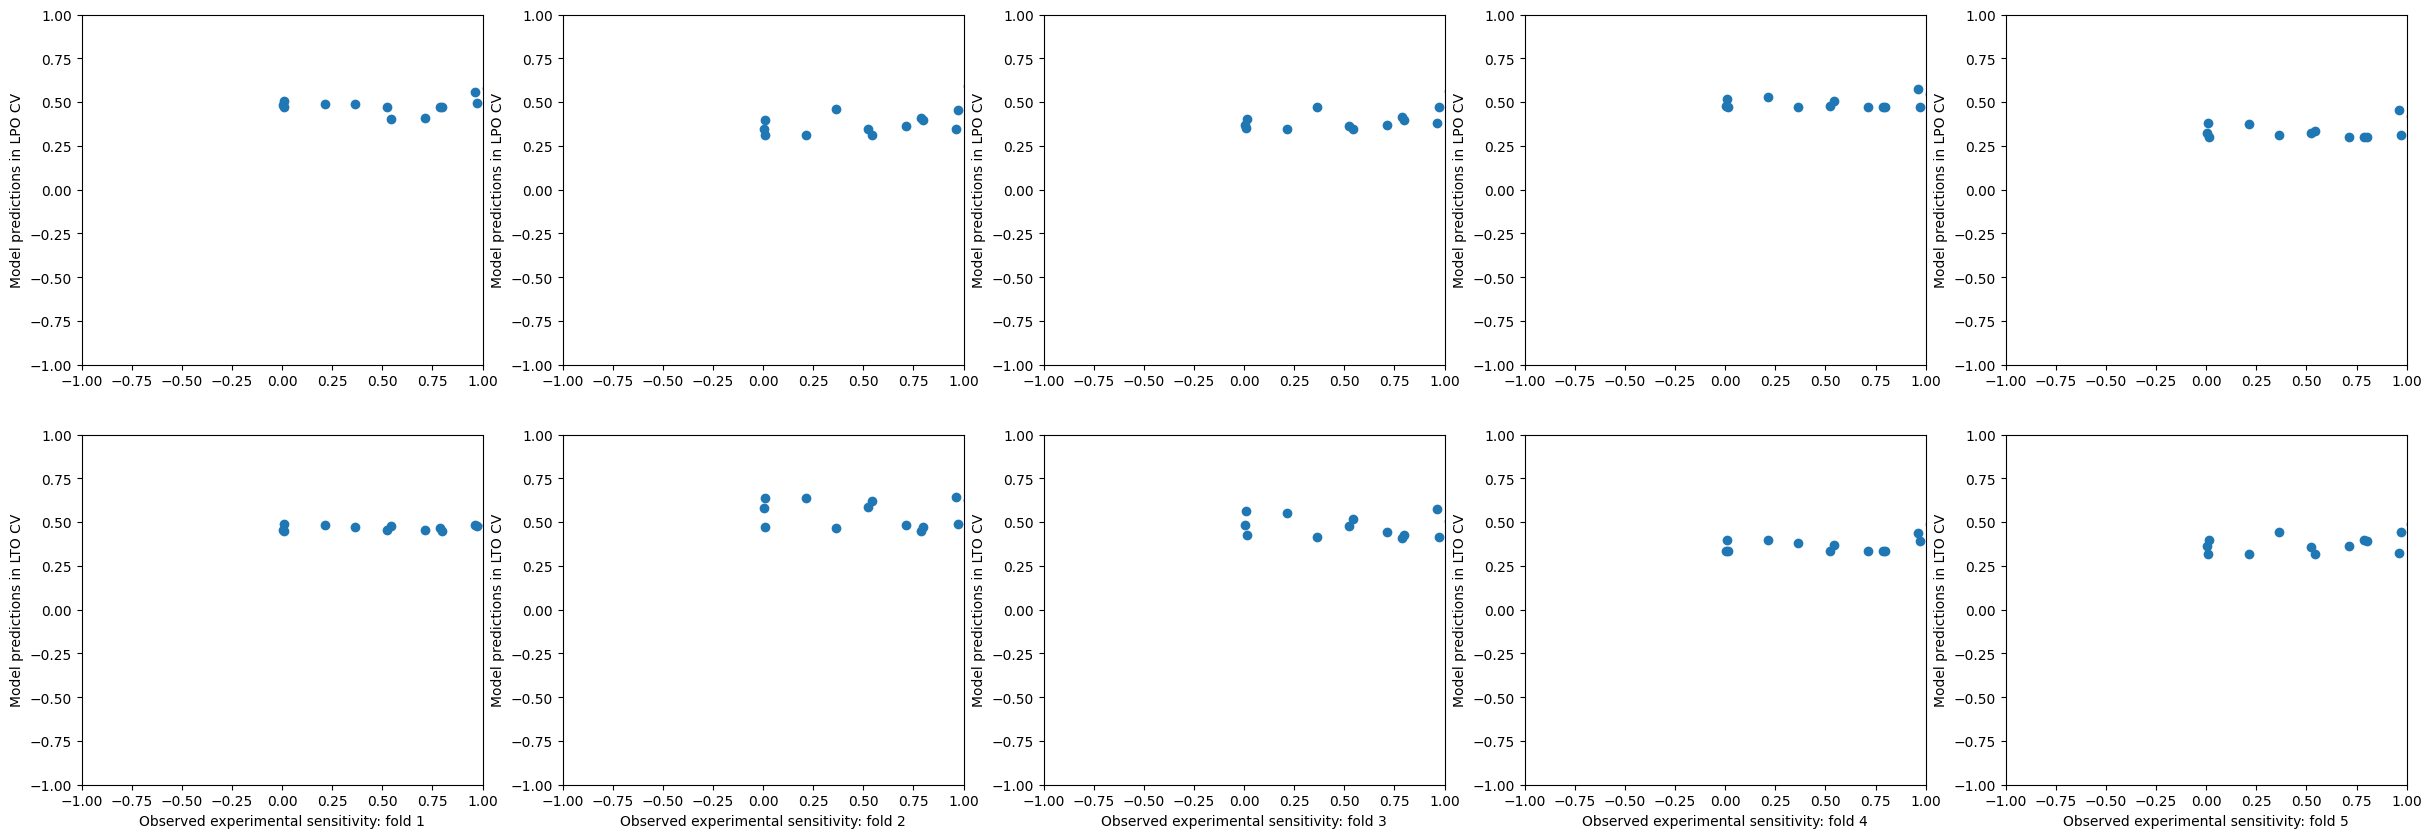

In [178]:
model.eval()
with torch.no_grad():
    for i, data in enumerate(test_dl):
        inputs, labels = data
labels = labels.to("cpu").numpy().reshape(-1)

plt.subplots(figsize=(30, 10))

test_pair_records = np.load("test_pair_outputs.npy")
for i in range(5):
    outputs = test_pair_records[i].reshape(-1)
    
    loss_test = loss_fn(outputs, labels).item()
    mae_test = mae_fn(outputs, labels).item()
    vx = voutputs - torch.mean(outputs)
    vy = vlabels - torch.mean(labels)
    pcc_test = torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2))).item()
    plt.subplot(2,5,i+1)
    plt.scatter(labels, outputs)
    plt.ylabel("Model predictions in LPO CV")
    plt.xlabel("MSE: {} MAE: {} PCC ")
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)

test_triplet_records = np.load("test_triplet_outputs.npy")
for i in range(5):
    outputs = test_triplet_records[i].reshape(-1)

    loss_test = loss_fn(outputs, labels).item()
    mae_test = mae_fn(outputs, labels).item()
    vx = voutputs - torch.mean(outputs)
    vy = vlabels - torch.mean(labels)
    pcc_test = torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2))).item()
    plt.subplot(2,5,i+1+5)
    plt.scatter(labels, outputs)
    plt.xlabel()
    plt.ylabel("Model predictions in LTO CV")
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)

